# Wearable Stress Detection using Machine Learning Classification Project
## CS543 : Massive Data Storage & Information Retrieval
### *By Deep Patel*
   This project's goal is to create a classifier that uses data from a smart fitness wearable to predict user's stress levels. This is an important problem as mental health is a growing dilemna and this tool can help people keep track of the their stress levels and also be used in real-time to stay calm in stressful situations. It can also help detect problems like long-term stress and alert designated people and avoid unhealthy long-term stress. For example, a parent may be able to track their children's stress levels overall so they can provide them with extra care and comfort in times when they are not feeling good or in adverse social situations. This is an interesting problem because it can help detect if you are depressed, over-worked, or any other type of stress that one might induce. In the age of data and the internet of things, this smart wearable can be easily marketed to people who care not only about their physical but also their mental health. It can be integrated into wearables like the Apple Watch, FitBit, and so many more.

## Data Pre-Processing
The dataset used is called WESAD, which stands for wearable stress and affect detection [1]. The dataset was made available on the UCI machine learning repository. It the result of a study done by a research team at Bosch Corp. in Germany. The data is recorded for 3 different affective states: neutral, stress, and amusement. Using this labelled data, machine learning can be used to classify a user's mental state in real-time using a wearable with sensors.  Data from ECG (Electrocardiogram), EDA (Electrodermal Activity), EMG (Electromyogram), Temperature, XYZ Acceleration, and Respiration sensors is being analyzed. The data is captured at 700 Hz, which is a lot of data points and becomes a deterrent for computational speed, so I filtered the data to only store data at 100 Hz, bringing down the size by 7 times. Another reason for bringing down the frequency is also that most commercial smartwatchs do not have sensors capable of such high frequency recordings. The  data is labelled by start and end times for each of the 5 different sessions of the study: Baseline, Stress, Meditation 1, Amusement, Meditation 2, where the stress and amusement sessions interchange for different subjects to minimize the effects of the order of the states. I first collect all the preprocessed data and converted it from raw signal data to meaningful sensor data in their corresponding SI units using instructions given by the sensor manufacteror, Respiban. Then, I labeled the data by parsing the timestamps from a csv file for each subject and then labelling the portions of the data for each sensor accordingly.

#### Import modules

In [531]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import neurokit as nk
import seaborn as sns
import math
import time
import sklearn
import random
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#### Collect Data and Store in DataFrame

In [2]:
n_skip = 7    # To skip over dense data (700 Hz -> 70 Hz)
freq = 700 / n_skip
subject_ids = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
sensor_list = ['ECG','EDA','EMG','TEMP','X','Y','Z','RESP']
df_respiban = [None for i in subject_ids]
for i in range(0,len(subject_ids)):
    df_respiban[i] = pd.read_csv('WESAD/S'+str(subject_ids[i])+'/S'+str(subject_ids[i])+'_respiban.txt', \
                    usecols=[2,3,4,5,6,7,8,9],header=None,comment='#',sep='\t',skiprows = lambda x: x %n_skip != 0)
    df_respiban[i].columns = sensor_list

#### Patch small holes (0-values) in data with interpolated data

In [3]:
for i in range(0,len(subject_ids)):
    for j in sensor_list:
        zero_list = df_respiban[i].index[df_respiban[i][j] == 0].tolist()
        if len(zero_list) > 0:
            for k in zero_list:
                filler_val = df_respiban[i].iloc[k-1][j] # assuming that k!=0 (1st entry is never 0), which is reasonable
                df_respiban[i].at[k,j] = filler_val

#### Map Raw Input Signal Values into SI units

In [4]:
def temp_convert(signal):
    vout = (signal*vcc)/(chan_bit-1.0)
    rntc = ((10.0**4)*vout)/(vcc-vout)
    temp = - 273.15 + 1.0/(1.12764514*(10**(-3)) + 2.34282709*(10**(-4))*math.log(rntc) + \
                           8.77303013*(10**(-8))*(math.log(rntc)**3))
    return temp
vcc = 3.0
chan_bit = 2.0**16
Cmin = 28000.0
Cmax = 38000.0
for i in range(0,len(subject_ids)):
    df_respiban[i]['ECG'] = df_respiban[i]['ECG'].apply(lambda signal: ((signal/chan_bit)-0.5)*vcc)
    df_respiban[i]['EDA'] = df_respiban[i]['EDA'].apply(lambda signal: ((signal/chan_bit)*vcc)/0.12)
    df_respiban[i]['EMG'] = df_respiban[i]['EMG'].apply(lambda signal: ((signal/chan_bit)-0.5)*vcc)
    df_respiban[i]['TEMP'] = df_respiban[i]['TEMP'].apply(temp_convert)
    df_respiban[i]['X'] = df_respiban[i]['X'].apply(lambda signal: (signal-Cmin)/(Cmax-Cmin)*2-1)
    df_respiban[i]['Y'] = df_respiban[i]['Y'].apply(lambda signal: (signal-Cmin)/(Cmax-Cmin)*2-1)
    df_respiban[i]['Z'] = df_respiban[i]['Z'].apply(lambda signal: (signal-Cmin)/(Cmax-Cmin)*2-1)
    df_respiban[i]['RESP'] = df_respiban[i]['RESP'].apply(lambda signal: ((signal / chan_bit) - 0.5) * 100)

#### Collect start/end time data for different study sessions and survey data
I planned on used this survey data to further gauge the actual level of stress in each subject and label the stress sessions with different weights for higher accuracy, but it turned out it was not needed and would bring extra complications, while also making the model less generalizable to other datasets.

In [5]:
subject_ids = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
df_survey = [None for i in subject_ids]
df_times = [None for i in subject_ids]
col_labels = [i for i in range(0,27)]
for i in range(0,len(subject_ids)):
    df_survey[i] = pd.read_csv('WESAD/S'+str(subject_ids[i])+'/S'+str(subject_ids[i])+'_quest.csv',sep=';')
    df_survey[i].columns = col_labels
    df_times[i] = df_survey[i].iloc[0:3,1:6]
    df_survey[i] = df_survey[i].iloc[4:]

#### Get starting and ending datapoint values for each study session

In [6]:
df_dp = [None for i in subject_ids]
for i in range(0,len(subject_ids)):
    df_dp[i] = df_times[i].copy(deep=True)
    for j in range(1,6):
        for k in range(1,3):
            if '.' in df_dp[i][j][k]:
                dot_index = df_dp[i][j][k].index('.')
                minute = int(df_dp[i][j][k][0:dot_index])
                second = int(df_dp[i][j][k][dot_index+1:])
                df_dp[i][j][k] = int(freq*(60*minute+second))
            else:
                df_dp[i][j][k] = int(freq*60*int(df_dp[i][j][k]))

## Visualizing the Data
Some graphs are printed out to show sensor data that is almost directly usable without having to do much feature extraction like for temperature and ECG, although this is not true for all subject's sensor data. We also see that some data like EDA, acceleration, and repiration, there is not much information in the data as given, but can be extracted through converting to the frequency domain for the physiological sensor data or using a sliding window approach to smooth the data for the physical acceleration sensor data. Another feature possible feature I can see to be useful would be using the standard mean and variance because it seems that the signal for repiration and some other sensors deviates from the mean more during stress than other states.

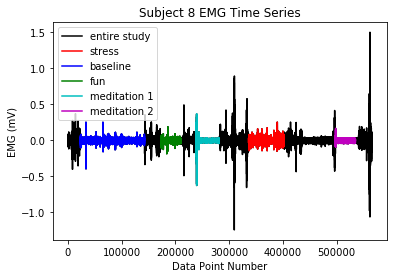

In [166]:
for i in range(6,7):
    sensor_index = 2
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' EMG Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('EMG (mV)')
    plt.show()

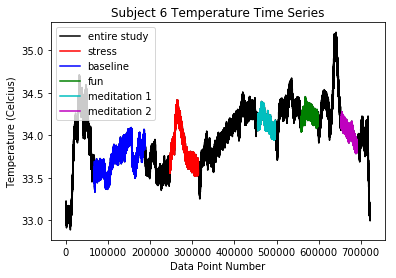

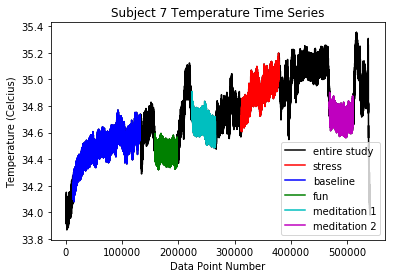

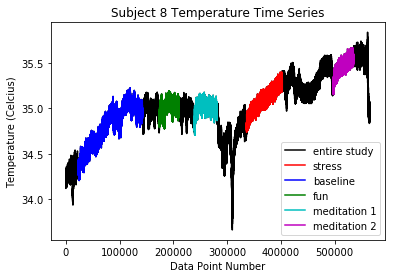

In [45]:
for i in range(4,7):
    sensor_index = 3
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' Temperature Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('Temperature (Celcius)')
    plt.show()

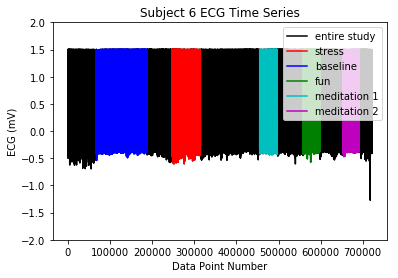

In [532]:
for i in range(4,5):
    sensor_index = 0
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' ECG Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('ECG (mV)')
    axes = plt.gca()
    axes.set_ylim([-2,2])
    plt.show()

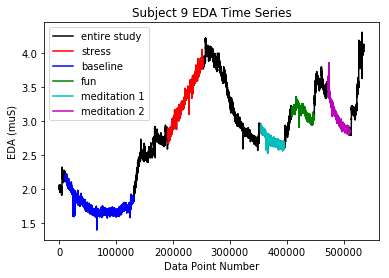

In [35]:
for i in range(7,8):
    sensor_index = 1
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' EDA Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('EDA (muS)')
    plt.show()

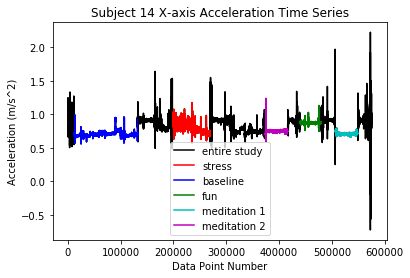

In [10]:
for i in range(11,12):
    sensor_index = 4
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' X-axis Acceleration Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('Acceleration (m/s^2)')
    plt.show()

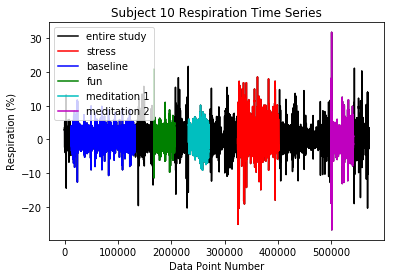

In [11]:
for i in range(8,9):
    sensor_index = 7
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(df_respiban[i][:][sensor_list[sensor_index]], 'k-', label='entire study')
    plt.plot(df_respiban[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]][sensor_list[sensor_index]],'r-', label='stress')
    plt.plot(df_respiban[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]][sensor_list[sensor_index]],'b-', label='baseline')
    plt.plot(df_respiban[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]][sensor_list[sensor_index]],'g-', label='fun')
    plt.plot(df_respiban[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]][sensor_list[sensor_index]],'c-', label='meditation 1')
    plt.plot(df_respiban[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]][sensor_list[sensor_index]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' Respiration Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('Respiration (%)')
    plt.show()

## Extracting Features
To understand the ECG and RESP signals, we must extract some features out of them. I am using a package called NeuroKit that does exactly that. It extracts information from the ECG and respiration signals to obtain simple values like heart rate, and heart beat positions. It also extracts some more complex values like Respiratory Sinus Arrhythmia, which is a naturally occurring variation in heart rate that occurs during a breathing cycle (inhalation and exhalation). This variation is directly affected by the autonomic nervous system, and thus, by measuring this variation of the heart rate during stress and non-stress conditions, we can capture useful information in classifying the two states.

To see which data is most useful, I have plotted it for all the subjects and analyzed all the features, as well as gotten their standard deviations and other metrics for analysis. For brevity, I have kept some findings for one subject and have only kept a few example plots that make it easy to visualize the type of things I was looking for in the features.

    Using multitaper spectrum estimation with 7 DPSS windows


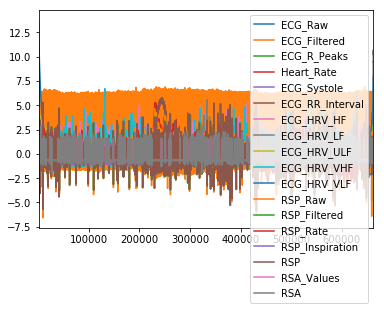

In [353]:
# Process Example ECG Signals for Visual Analysis
i = 1
bio = nk.bio_process(ecg=df_respiban[i][:]['ECG'],rsp=df_respiban[i][:]['RESP'], ecg_quality_model=None, ecg_filter_frequency=[1,35], sampling_rate=100)

# Plot the processed dataframe, normalizing all variables for viewing purpose
nk.z_score(bio["df"][1000:-1000]).plot()
plt.show()

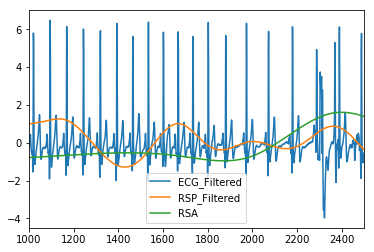

In [551]:
nk.z_score(bio["df"][["ECG_Filtered", "RSP_Filtered", "RSA"]])[1000:2500].plot()
plt.show()

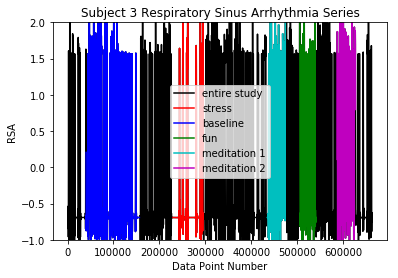

In [552]:
rsa_values = [0,0]
for i in range(1,2):
    rsa_values[i] = nk.z_score(bio["df"]['RSA'])
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(rsa_values[i][:], 'k-', label='entire study')
    plt.plot(rsa_values[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]],'r-', label='stress')
    plt.plot(rsa_values[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]],'b-', label='baseline')
    plt.plot(rsa_values[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]],'g-', label='fun')
    plt.plot(rsa_values[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]],'c-', label='meditation 1')
    plt.plot(rsa_values[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' Respiratory Sinus Arrhythmia Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('RSA')
    axes = plt.gca()
    axes.set_ylim([-1,2])
    plt.show()

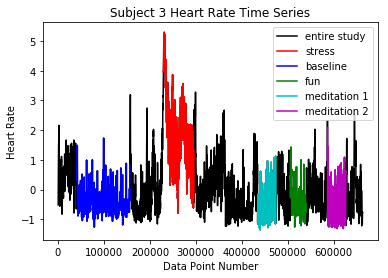

In [165]:
hr_values = [0,0]
for i in range(1,2):
    hr_values[i] = nk.z_score(bio["df"]['Heart_Rate'])
    stress_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0]  
    base_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Base'][0]   
    fun_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Fun'][0]   
    medi1_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 1'][0]   
    medi2_index = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='Medi 2'][0]   

    plt.plot(hr_values[i][:], 'k-', label='entire study')
    plt.plot(hr_values[i][df_dp[i][stress_index][1]:df_dp[i][stress_index][2]],'r-', label='stress')
    plt.plot(hr_values[i][df_dp[i][base_index][1]:df_dp[i][base_index][2]],'b-', label='baseline')
    plt.plot(hr_values[i][df_dp[i][fun_index][1]:df_dp[i][fun_index][2]],'g-', label='fun')
    plt.plot(hr_values[i][df_dp[i][medi1_index][1]:df_dp[i][medi1_index][2]],'c-', label='meditation 1')
    plt.plot(hr_values[i][df_dp[i][medi2_index][1]:df_dp[i][medi2_index][2]],'m-', label='meditation 2')
    plt.legend()
    plt.title('Subject '+str(subject_ids[i])+' Heart Rate Time Series')
    plt.xlabel('Data Point Number')
    plt.ylabel('Heart Rate')
#     axes = plt.gca()
#     axes.set_ylim([-1,2])
    plt.show()

### Getting Features Function
From these results and from research as referenced below, there are some features that seems to be obvious indicators of stress. The function below takes features from the biosignals processing and from the sensor signals themselves to create the final feature arrays for a given window.

In [404]:
# Define window size
window_size = freq*60      # 60 second window * frequency = number of data points per window
num_features = 15

# Function to extract all features including advanced biosignals features
def getfeatures(df):
    features = [None for i in range(num_features)]
    bio = nk.bio_process(ecg=df[:]['ECG'],rsp=df[:]['RESP'], ecg_quality_model=None, sampling_rate=freq)
    
    # Temperature Features: Mean, STD, Slope, Range, Max, Min
    features[0] = df['TEMP'].mean()
    features[1] = df['TEMP'].std()  
    features[2] = (df['TEMP'].iloc[-1] - df['TEMP'].iloc[0]) / window_size
    features[3] = abs(df['TEMP'].iloc[-1] - df['TEMP'].iloc[0])
    features[4] = df['TEMP'].max()
    features[5] = df['TEMP'].min()
    
    # ECG Heart Rate Statistics:
    features[6] = bio['df']['Heart_Rate'].mean()
    features[7] = bio['df']['Heart_Rate'].std()
    features[8] = bio['df']['Heart_Rate'].mean()
    
    # RSA Statistics:
    features[9] = bio['ECG']['RSA']['RSA_P2T_Mean']
    features[10] = bio['ECG']['RSA']['RSA_P2T_Variability']
    
    # RESP Features
    features[11] = bio['RSP']['Respiratory_Variability']['RSPV_SD']
    features[12] = bio['RSP']['Respiratory_Variability']['RSPV_RMSSD']

    # EMG Features: STD
    features[13] = df['EMG'].std()
    
    # NOTE: NOT ABLE TO USE THESE FEATURES BECAUSE HRV IS NOT ABLE TO BE CALCULATED IN 60 SEC BY NEUROKIT
    # KEEPING HERE TO KNOW THAT THESE FEATURES CAN BE USED TO INCREASE ACCURACY/PERFORMANCE IF IMPLEMENTED SOME OTHER WAY
        # ECG Features: 
    # Heart Rate Variability Properties:
#     features[6] = bio['ECG']['HRV']['HF']
#     features[7] = bio['ECG']['HRV']['HF/P']
#     features[8] = bio['ECG']['HRV']['HFn']
#     features[9] = bio['ECG']['HRV']['LF']
#     features[10] = bio['ECG']['HRV']['LF/HF']
#     features[11] = bio['ECG']['HRV']['LF/P']
#     features[12] = bio['ECG']['HRV']['LFn']
#     features[13] = bio['ECG']['HRV']['Total_Power']
#     features[14] = bio['ECG']['HRV']['Triang']
#     features[15] = bio['ECG']['HRV']['ULF']
#     features[16] = bio['ECG']['HRV']['VHF']
#     features[17] = bio['ECG']['HRV']['VLF']

    return features

### Creating the Feature Arrays from all the Data
Next, we set the window size and iterate over all the data from all the subjects to get all the labelled feature arrays. I chose to set a window size of 60 seconds, (which corresponds to 6000 data points because it is at 100Hz) because research has shown that the features extracted from the ECG signal need around that much time to measure and calculate the desired features. Furthermore, the windows will have a 50% overlap. In other words, it will be a sliding window of size 60 seconds and step 30 seconds. I found this to be a good practice because of two reasons. Firstly, this means that the user will get stress notifications every 30 seconds, as apposed to 60 seconds. Also, it means that the part of the data which is not fully in the stressed state will be analyzed better by sliding the window half of the way and analyzing again. Lastly, the windows are labelled with a stress and non-stress label by checking whether the midpoint of the window in is the stressed region. Essentially, what this does is label the window as stressed if more than half of the window is part of the stressed label, and non-stress if otherwise. This is a reasonable assumption because in practice, for every 60 seconds, the user may not be fully stressed the whole time (like if they start to feel stressed starting at the 50th second) and thus, the label should be non-stress. This helps train the model for such situations, while being able to use the full data, instead of chunking it into sections of exactly one state in a black and white way.

Note: I have suppressed the output for this function, as NeuroKit gives many warnings that overfill the output.

In [358]:
# To suppress NeuroKit warnings
import contextlib
import io
import sys

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

with nostdout():
    # Process the ECG signals
    time_start_features = time.time()
    feature_arr = []
    for i in range(0,len(subject_ids)):
        total_datapoints = len(df_respiban[i].index)
        curr_start = 0
        while curr_start + window_size <= total_datapoints:
            curr_end = curr_start + window_size
            # Get the indices for the stress session part of the data
            stress_indices = df_dp[i].iloc[0].index[df_dp[i].iloc[0] =='TSST'][0] 
            stress_start = df_dp[i][stress_indices][1]
            stress_end = df_dp[i][stress_indices][2]
            midpoint = (curr_start + curr_end) / 2
            curr_state = -1
            if (midpoint >= stress_start) and (midpoint <= stress_end):
                curr_state = 1
            features = getfeatures(df_respiban[i][curr_start:curr_end])
            features[-1] = curr_state
            feature_arr.append(features)
            curr_start = curr_start + window_size/2
total_time_taken_features = time.time() - time_start_features


The time taken to process a window of a signal is an important metric to consider, as this determines how much of a delay there is between a user feeling stress and how long it takes for them to get notified. As you can see, from the time below, the time taken is quite low and so this method is suitable for real-time applications. Note, that the test data and training data is processed simultaneously, but this does not change the results, as each window is independent of the others and the time taken to process the data for features is the same for getting the training and during processing for prediction in real-time applications.

In [361]:
# Taken taken to process signal and extract features from 1 window:
average_time_per_window = total_time_taken_features / len(feature_arr)
print "Average Window Calculation Time:", average_time_per_window, "sec"

Average Window Calculation Time: 0.259694015787 sec


# Modeling and Classification
## Machine Learning Model 1: AdaBoost
To model and classify the data I use the Adaptive Boosting, or AdaBoost algorithm with the base ML model as a unilevel decision tree with 400 estimators and a learning rate of 1. This was my choice because the algorithm has been very successful in the field of ML and I have gotten very good results as compared to using a single model like random forest or k-nearest neighbors on its own. I chose to use 10% of the data as the test data and the rest for training. The data is first shuffled, so that the stress windows are not grouped together as they are when the features are extracted from the sensor data, and so that the ordering of the data does not bias the model. So, by shuffling the features first, the stress and non-stress conditions become mixed and randomized. Every time the algorithm is run, the features are again shuffled, so that a different 10% of the data is used for testing in each iteration. After several iterations of this, I have seen that the accuracy for both the discrete and real AdaBoost variations remains steady at between 88% to 92%. The graph plotted below shows the training and testing error as a function of the number of estimators added. We can see that test error starts to level out as the number of estimators increases, assuring that we have a good choice for the number of estimators and more may overfit the data.

Model Training Time: 7.71218109131 sec


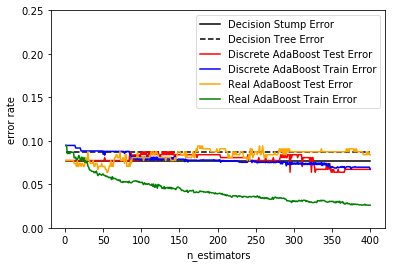

In [553]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

n_estimators = 400                                   # Set number of estimating classifiers in the model
learning_rate = 1.                                   # Set learning rate of algorithm

random.shuffle(feature_arr)                          # Randomize order of datapoints to remove bias of order
test_percentage = 0.1                                # Set percentage of data used for testing
test_index = int(len(feature_arr)*test_percentage)   # Get ending test data index

X_test, y_test, X_train, y_train = [], [], [], []
# Populate testing and training data variables and labels, X and Y
for i in range(0, test_index):
    X_test.append(np.array(feature_arr[i][:-1]))
    y_test.append(feature_arr[i][-1])
for i in range(test_index, len(feature_arr)):
    X_train.append(np.array(feature_arr[i][:-1]))
    y_train.append(feature_arr[i][-1])
    
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)

start_time = time.time()

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

training_time = time.time() - start_time
print "Model Training Time:",training_time,"sec"
    
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.25))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()


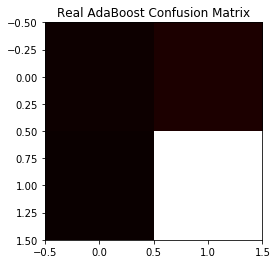

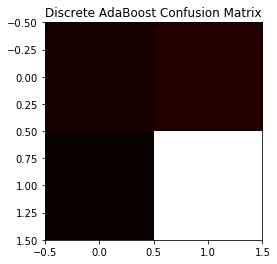


Adaboost Real Accuracy:            91.5824915825 %
Adaboost Real F1-score:            44.4444444444 %
Adaboost Real Prediction Time:     0.0620419979095 sec
Adaboost Discrete Accuracy:        93.265993266 %
Adaboost Discrete F1-score:        52.380952381 %
Adaboost Discrete Prediction Time: 0.0720059871674 sec



In [554]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

y_true = y_test

# Make Predictions on test data
start_time = time.time()
y_pred_real = ada_real.predict(X_test)
real_pred_time = time.time() - start_time
start_time = time.time()
y_pred_discrete = ada_discrete.predict(X_test)
discrete_pred_time = time.time() - start_time

# Get F1-scores and plot confusion matrices
fl_real = f1_score(y_true, y_pred_real, average='binary')
fl_discrete = f1_score(y_true, y_pred_discrete, average='binary')
cm_real = confusion_matrix(y_true, y_pred_real, labels=[1,-1])
cm_discrete = confusion_matrix(y_true, y_pred_discrete, labels=[1,-1])
plt.imshow(cm_real, cmap='hot', interpolation='nearest')
plt.title('Real AdaBoost Confusion Matrix')
plt.show()
plt.imshow(cm_discrete, cmap='hot', interpolation='nearest')
plt.title('Discrete AdaBoost Confusion Matrix')
plt.show()

# Get accuracy
accuracy_real = ada_real.score(X_test, y_test)
accuracy_discrete = ada_discrete.score(X_test, y_test)
print color.BOLD
print "Adaboost Real Accuracy:           ", accuracy_real*100, "%"
print "Adaboost Real F1-score:           ", fl_real*100, "%"
print "Adaboost Real Prediction Time:    ",real_pred_time,"sec"
print "Adaboost Discrete Accuracy:       ", accuracy_discrete*100, "%"
print "Adaboost Discrete F1-score:       ", fl_discrete*100, "%"
print "Adaboost Discrete Prediction Time:",discrete_pred_time,"sec"
print color.END

## Machine Learning Model 2: Two-Layer Artificial Neural Network
The next model I use is a 2-layer ANN, where the size of the layers is 4 times the input size. The activation function I chose is ReLU and for the output, a sigmoid function is used to extract the binary classification. The model is run for 400 epochs with a batch size of 100 feature tensor inputs. Similarly to before, the training and testing data is split 90/10.


In [547]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

random.shuffle(feature_arr)                          # Randomize order of datapoints to remove bias of order
test_percentage = 0.1                                # Set percentage of data used for testing
test_index = int(len(feature_arr)*test_percentage)   # Get ending test data index

X_test, y_test, X_train, y_train = [], [], [], []
# Populate testing and training data variables and labels, X and Y
for i in range(0, test_index):
    X_test.append(np.array(feature_arr[i][:-1]))
    if feature_arr[i][-1] == 1:
        y_test.append([1])
    else:
        y_test.append([0])
for i in range(test_index, len(feature_arr)):
    X_train.append(np.array(feature_arr[i][:-1]))
    if feature_arr[i][-1] == 1:
        y_train.append([1])
    else:
        y_train.append([0])
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

# print Tensor Sizes
print "Train Input Size:", X_train.size()
print "Train Label Size:", y_train.size()
print "Test Input Size:", X_test.size()
print "Test Label Size:", y_test.size()


Train Input Size: torch.Size([2679, 14])
Train Label Size: torch.Size([2679, 1])
Test Input Size: torch.Size([297, 14])
Test Label Size: torch.Size([297, 1])


#### Define Artificial Neural Network Model Architecture

In [548]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear((num_features-1), (num_features-1))
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear((num_features-1), (num_features-1)*4)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear((num_features-1)*4, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

#### Define Epoch Training Function

In [549]:
def train_epoch(model, opt, criterion, batch_size):
    model.train()
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

#### Train the Model

Model Training Time: 9.12899279594 sec


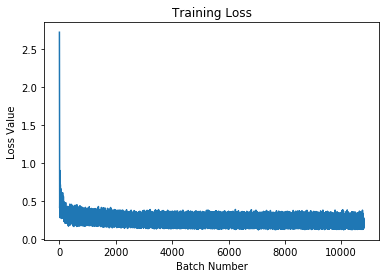

In [550]:
start_time = time.time()
e_losses = []
num_epochs = 400
batch_size = 100
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion, batch_size)
training_time = time.time() - start_time
print "Model Training Time:",training_time,"sec"
plt.plot(e_losses)
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss Value')
plt.show()

### Predict using Model with Test Data

In [541]:
start_time = time.time()
prediction = net(Variable(X_test))
correct = 0.0
total = float(len(prediction))
for i in range(0, len(prediction)):
    if (prediction.data[i] > 0.5).numpy():
        if (y_test[i] == 1).numpy():
            correct += 1
    else:
        if (y_test[i] == 0).numpy():
            correct += 1
print color.BOLD
print "Test Accuracy:", correct/total*100, "%"
print  "Prediction Time Taken:",time.time()-start_time,"sec"
print color.END


Test Accuracy: 90.2356902357 %
Prediction Time Taken: 0.00850009918213 sec



# Results
To summarize, two machine learning models are used for the classification of stress vs. non-stress using wearable sensor data: Adaboost and an Feed-Forward Artificial Neural Network.

I have used the both the discrete and real Adaboost algorithms with the classifier in both cases being a decision tree of depth 1 to train and test the labelled data. The difference is that the discrete version dapts based on the error in the predicted class labels, wheres the real version uses predicted class probabilities.

For the ANN, I used a 2 fully connected layers, with ReLU as the activation function for both and a sigmoid function at the last step to obtain the output layer nodes. By increasing the size of the hidden layers I was able to see a better accuracy and faster decline of the less error. The training of the data was done for 400 epochs, as I saw that increasing it did in fact lower the trining loss slightly, but started to level out, and would not give much increase in performance in prediction accuracy.

The resulting accuracies for both methods were similar at around 90% for AdaBoost and 92% for the Feed-Forward Neural Network. This shows that the features extracted are in fact quality features and useful in detecting stress. I was also quite surprised at the speed of the algorithms and their success. I was initially planning on using deep learning to tackle the classification task, but erred away from the idea because firstly, it would require a lot more data than was available to me, and also the types of features extracted from the ECG signal are complex, using functions like Fourier transforms, peak detection algorithms, and frequency pass filters. In my opinion would be hard top using deep learning, which also would take much longer in real-time application.

In comparison to the makers of the dataset, on average, I was able to match their test accuracy using AdaBoost and with the neural network I was able to get a test accuracy of 1% higher. This shows that there is potential for neural networks to approximate the data better than classical machine learning algorithms that they used.

# Conclusion
This project really gave me a lot of insights into all the different steps there are to go from raw data to a final application. Furthermore, it also allowed me to explore the multitude of useful resources there are for big data processing that allow you to do many things without having to build function on your own form the ground up. One of the difficulties I had in the project was pre-processing all the data. The data format was vaguely described with the time labels of the sessions in odd formats and some missing patches. I was able to overcome this by reading all the documentation and finding some tricks that would make it efficient to label the data, convert it from raw signals to SI units, and fill patches in the data with filler values. Furthermore, the results show that the classifier is robust enough to differentiate between different arousal states like stress and joy, which was something I suspected might be a problem. 


# Future Work 
If I were to continue this project, I had another idea that would involve the use of a convolutional neural network. Essentially, this project focuses on real-time application of stress detection. On the other hand, an offline method for stress detection is also useful, like getting an hourly, daily, or even weekly summary of your stress record. My thoughts were to create graphs like I did above that color the stress section with red for the different sensors and even for the extracted features graphs. Using these labelled graphs, I could train a convolutional neural network to predict what parts of a given input graph in the future, "should be colored red", or, in other words, associates with stress in that part of the day. This can give the user a graph when they were most stressed and allow them to work on their stress control by pinpoints its occurances and thus, sources.

Another future idea I had is to use the acceleration data to detect whether the user is exercising or not. This would allow a second order of classification, so the user can differentiate good stress (exercise-induced) and bad stress (mentally-induced).


# Acknowledgments & References
### Software
   - PySpark
   - NeuroKit
   - NumPy
   - Matplotlib
   - Sci-Kit Learn
   - PyTorch
   
### Related Work / Research Papers
[1] Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger, and Kristof  Van  Laerhoven. Introducing  WESAD,  a  multimodal  dataset  forwearable  stress  and  affect  detection. In Proceedings of the 20th ACMInternational Conference on Multimodal Interaction,  ICMI  ’18,  pages400–408, New York, NY, USA, 2018. ACM.

[2] Alexandratos, V, Jonker, C.M. (mentor). Mobile Real-Time Stress Detection. Master's Thesis.
[uuid:c3e56b27-97ff-459b-9f85-dc05f8e3c088](uuid:c3e56b27-97ff-459b-9f85-dc05f8e3c088)
